In [57]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
from PIL import Image
import glob

In [58]:
filelist = glob.glob('data/pets/*.jpg')
x_pets = np.array([np.array(Image.open(fname)) for fname in filelist])
filelist = glob.glob('data/vangogh/*.jpg')
x_vangogh = np.array([np.array(Image.open(fname)) for fname in filelist])

/tmp/ipykernel_30046/1397748022.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_pets = np.array([np.array(Image.open(fname)) for fname in filelist])
/tmp/ipykernel_30046/1397748022.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_vangogh = np.array([np.array(Image.open(fname)) for fname in filelist])


In [59]:
import matplotlib.pyplot as plt


def display(array1, arrays=None, n=20):
    if arrays is None:
        arrays = []
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]

    rows = 1 + len(arrays)

    plt.figure(figsize=(20, 4))
    for i, image1 in enumerate(zip(images1)):
        ax = plt.subplot(rows, n, i + 1)
        plt.imshow(np.reshape(image1, (28, 28)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    for arrayIndex in range(len(arrays)):
        arrayImages = arrays[arrayIndex]
        images = arrayImages[indices, :]
        for i, (image) in enumerate(zip(images)):
            ax = plt.subplot(rows, n, i + 1 + n * (arrayIndex + 1))
            plt.imshow(np.reshape(image, (28, 28)))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.5
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

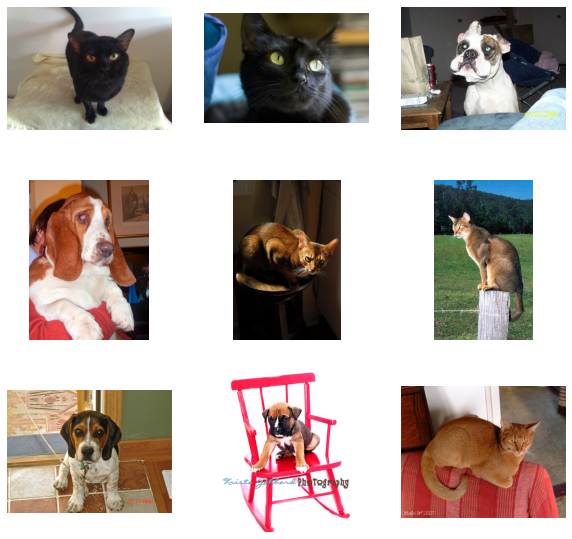

In [60]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(x_pets[i]).astype("uint8"))
    plt.axis("off")

In [61]:
van_gogh_validator = keras.Sequential([
    layers.Input(shape=(None, None, 3)),
    layers.Conv2D(3, (1, 1), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(1, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Reshape(target_shape=(1, 1)),
    layers.Dense(1, activation='sigmoid')
])
van_gogh_validator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, None, None, 3)     12        
                                                                 
 max_pooling2d_8 (MaxPooling  (None, None, None, 3)    0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 128)   3584      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 64)    73792     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, None, None, 64)  

In [62]:
transformer_pets_to_van_gogh = keras.Sequential([
    layers.Dense(32, input_shape=(None, None, 3), name='layer_dense'),
    layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same', name='first_conv2D'),
    layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same', name='second_conv2D'),
    layers.Conv2DTranspose(3, (3,3), strides=1, activation='relu', padding='same', name='third_conv2D'),
])
transformer_pets_to_van_gogh.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_dense (Dense)         (None, None, None, 32)    128       
                                                                 
 first_conv2D (Conv2DTranspo  (None, None, None, 32)   9248      
 se)                                                             
                                                                 
 second_conv2D (Conv2DTransp  (None, None, None, 64)   18496     
 ose)                                                            
                                                                 
 third_conv2D (Conv2DTranspo  (None, None, None, 3)    1731      
 se)                                                             
                                                                 
Total params: 29,603
Trainable params: 29,603
Non-trainable params: 0
__________________________________________________

In [63]:
# Générateur
transformer_pets_to_van_gogh.compile(loss="binary_crossentropy", optimizer="adam")
# Discriminator
van_gogh_validator.compile(loss="binary_crossentropy", optimizer="adam")

In [64]:
van_gogh_validator.trainable=False

z = keras.layers.Input(shape=(None,None,3))
image = transformer_pets_to_van_gogh(z)

valid = van_gogh_validator(image)

combined_network = keras.Model(z,valid)
combined_network.compile(loss='binary_crossentropy',optimizer='adam')


1/1 [==============================] - 0s 489ms/step


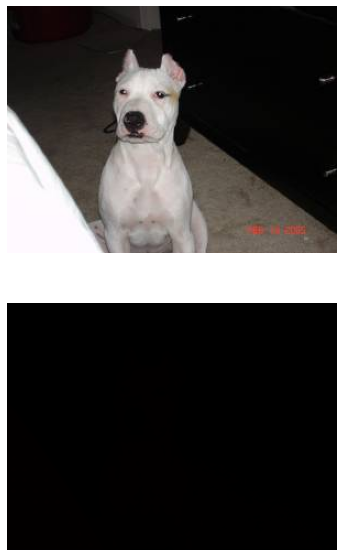

In [65]:
def display_images():
    r, c = 2, 1

    index = np.random.randint(0, x_pets.shape[0], c)
    pets_images = [x.tolist() for x in x_pets[index]]


    generated_images = transformer_pets_to_van_gogh.predict(pets_images)

    #Scaling the generated images
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=(10, 10))
    for i in range(c):
        ax = plt.subplot(r, c, i + 1)
        plt.imshow(np.array(pets_images[i]).astype("uint8"))
        plt.axis("off")

    for i in range(c):
        ax = plt.subplot(r, c, c + i + 1)
        plt.imshow(np.array(generated_images[i]).astype("uint8"))
        plt.axis("off")

    plt.show()
    plt.close()


display_images()

In [78]:
num_epochs = 5
batch_size = 1

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size,1))

display_interval = 1
valid = 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)
for epoch in range(num_epochs):

    index = np.random.randint(0, x_pets.shape[0], batch_size)
    pets_images = [x.tolist() for x in x_pets[index]]

    vangogh_index =  np.random.randint(0, x_vangogh.shape[0], batch_size)
    vangogh_images = [x.tolist() for x in x_vangogh[vangogh_index]]

    generated_images = transformer_pets_to_van_gogh.predict(pets_images)
    discm_loss_real = van_gogh_validator.train_on_batch(vangogh_images, valid)
    discm_loss_fake = van_gogh_validator.train_on_batch(generated_images, fake)

    genr_loss=combined_network.train_on_batch(noise,valid)



    if epoch % display_interval == 0:
        print("EPOCH === ", epoch)
        print('Generator loss = ', genr_loss)
        print('Discriminator_loss = ', discm_loss_fake)
        display_images()


1/1 [==============================] - 1s 1s/step


AttributeError: 'int' object has no attribute 'shape'